# 3D the Quasi-Biennial Oscillation (QBO) using ECMWF ERA-20C

In this tutorial we will explore the ERA-20C dataset provided by ECMWF. In particular, we will try to identify the so-called Quasi-Biennial Oscillation (QBO), that has a period of approximately 28 to 29 months. QBO has a characteristic quasi-periodic reversals of the zonal-mean zonal winds in the equatorial stratosphere between easterlies and westerlies with a distinct apparent downward phase propagation of the alternating wind regimes, see for example *Baldwin et al., The quasi-biennial oscillation, 2003*, and  *Schmidt et al., Spectral Empirical Orthogonal Function Analysis of Weather and Climate Data, 2019*

This mode of variability has important implications in terms of tele-connections in the Northern Hemisphere, and can be identified by using the 10hPa zonal component of the wind velocity. In particular, we will use monthly mean reanalysis data from 1900 to 2010, defined on 240 longitude points, 121 latitude points, and 18 vertical levels. 

## Download data

The first step to use `PySPOD` for investigating the Quasi-Biennial Oscillation (QBO) is to download the relevant data. This step can require a few hours, depending on your internet connection and on how busy ECMWF server is. Also, please note that the amount of data that needs to be downloaded is approximately 1.30GB. 

In order to download the required data from ECMWF, you should create an account and follow the instructions here: https://confluence.ecmwf.int/display/WEBAPI/Access+ECMWF+Public+Datasets

Once you have an account to access ECMWF data, you can simply run:
`python3 E20C_MONTHLYMEAN00_1900_2010_U131128_3D.py`

This should download a netCDF file called `E20C_MONTHLYMEAN00_1900_2010_U131128_3D.nc` in the current directory `tutorials/climate/ERA20C_QBO_3D/`. Please, make sure that this is the case. 

## Loading and configuring data

Once we have gained access to ECMWF datasets and downloaded the required file `E20C_MONTHLYMEAN00_1900_2010_MEI.nc`, we can proceed to use `PySPOD` to identify coherent structures in the data. The first step from this perspective is to import the required libraries, including the custom libraries 
- `from pyspod.spod_low_storage import SPOD_low_storage`
- `from pyspod.spod_low_ram     import SPOD_low_ram`
- `from pyspod.spod_streaming   import SPOD_streaming`

that include three different implementations of the SPOD algorithm, the first requiring low storage memory (intended for large RAM machines or small amount of data), the second requiring low RAM (intended for large dataset or small RAM machines), and the third being a streaming algorithm, that required little amount of memory (both storage and RAM) but runs typically slower than the other two.

Note that we also import the custom library 
- `import library.weights as weights`

that implements the weight matrix for data defined on a sphere (e.g. the atmospheric data we are using). 

In [3]:
import os
import sys
import time
import warnings
import xarray as xr
import numpy  as np
from pathlib import Path

# Import library specific modules
sys.path.append("../../../")
from pyspod.spod_low_storage import SPOD_low_storage
from pyspod.spod_low_ram     import SPOD_low_ram
from pyspod.spod_streaming   import SPOD_streaming
import pyspod.weights as weights

# Current path
CWD = os.getcwd()

We then need to load the data from the netCDF file and inspect:

In [4]:
# Inspect and load data 
file = os.path.join(CWD,'E20C_MONTHLYMEAN00_1900_2010_MEI.nc')
ds = xr.open_dataset(file)
print(ds)

<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 240, time: 1332)
Coordinates:
  * longitude  (longitude) float32 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
  * latitude   (latitude) float32 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * time       (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2010-12-01
Data variables:
    sst        (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
    tcc        (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-10-25 20:57:11 GMT by grib_to_netcdf-2.19.0: grib_to_n...


the netCDF file contains 3 coordinates:
- longitude
- latitude,  
- time, 

along with 6 variables

- sst (sea surface temperature)
- msl (mean seal level pressure)
- tcc (total cloud cover)
- u10 (horizontal velocity; u-component)
- v10 (horizontal velocity; v-component)
- t2m (2-meters temperature)

We first load `time`, and the two spatial coordinates `longitude` and `latitude`, and we store them into three different arrays, `t`, `x1` and `x2`, respectively. Let's look at their dimensions to see the number of time snapshots, and the length of longitude and latitude.

In [7]:
# we extract time, longitude and latitude
t = np.array(ds['time'])
x1 = np.array(ds['longitude'])
x2 = np.array(ds['latitude'])
print('shape of t (time): ', t.shape)
print('shape of x1 (longitude): ', x1.shape)
print('shape of x2 (latitude) : ', x2.shape)

shape of t (time):  (1332,)
shape of x1 (longitude):  (240,)
shape of x2 (latitude) :  (121,)


We then need to load the data in a format that is suitable to the `PySPOD` library, that is
- first dimension must correspond to the number of time snapshots (1332 in our case)
- last dimension should corresponds to the number of variables (6 in our case)
- the remaining dimensions corresponds to the spatial dimensions (240, and 121 in our case, that correspond to longitude and latitude).

Let's load and reshuffle it, in order to meet this requiremnt, and check its dimensions. 

In [10]:
# we set the variables we want to use for the analysis
# (we select all the variables present) and load the in RAM
variables = ['sst', 'msl', 'tcc', 'u10', 'v10', 't2m']
X = np.empty([t.shape[0], x1.shape[0], x2.shape[0], len(variables)])
for i,var in enumerate(variables):
	X[...,i] = np.einsum('ijk->ikj', np.array(ds[var]))
	X[...,i] = np.nan_to_num(X[...,i])
print('shape of data matrix X: ', X.shape)

shape of data matrix X:  (1332, 240, 121, 6)


We can see that: 
- the **first dimension is 1332**, and corresponds to the **number of time snapshots**; 
- the **second is 240**, and corresponds to the **number of longitude points**;
- the **third is 121**, and corresponds to the **number of latitude points**;
- the **fourth is 6**, and corresponds to the **number of variables**.

Indeed, we use as first dimension the number of time snapshots, as last dimension the number of variables and as middle dimensions, the spatial dimensions, that in our case are two and correspond to longitude and latitude.\

<font color='green'> **NOTE: we used `np.nan_to_num` to set possible NaN (not-a-number) to zero. The amount of NaN in this case is relatively small, and setting them to zero is a feasible approximation. For your specific application you might want to apply a different replacement for NaN (if present).**</font>

## Setting required and optional parameters

Once our data is in a shape suitable to the `PySPOD` library, we define the **required** and **optional parameters**. In particular, we define a dictionary of parameters, that will be passed to the constructor of `PySPOD`. 

The required parameters are as follows:
- `dt`: time-sampling of the data (for now this must be constant)
- `nt`: number of time snapshots
- `xdim`: number of spatial dimensions
- `nv`: number of variables
- `n_FFT`: length of FFT blocks
- `n_freq`: number of frequencies
- `n_overlap`: dimension of the overlap region between adjacent blocks
- `mean`: type of mean to be subtracted from the data
- `normalize`: data normalization by data variance
- `savedir`: where to save the data
- `weights`: weights to be used to compute the inner product

The optional parameters are as follows:
- `savefreqs`: number of frequencies to be saved
- `n_modes_save`: number of modes to be saved
- `normavar`: normalize data by variance
- `conf_level`: calculate confidence level of modes
- `savefft`: save FFT blocks to reuse them in the future (to save time)


<font color='green'> **Note: we used the built-in module `weights`, and in particular the function `weights.geo_weights_trapz_2` to construct the weights for our problem on the sphere. This function builds weights according to lon-lat grids on the sphere and can be generally used for  two-dimensional atmospheric data. You can implement your own weights by adding a method into `weights.py` or by readily providing the weights as a numpy.ndarray of that must have the dimensions of the flattened data per each time-step, that is:**
    
$$\textsf{weights dim} = \textsf{number of spatial points} \times \textsf{number of variables}$$. </font>

In [11]:
# define required and optional parameters
params = dict()

# required parameters
params['dt'          ] = 720 # data time-sampling
params['nt'          ] = 1340 # number of time snapshots
params['xdim'        ] = 2   # number of spatial dimensions (longitude and latitude)
params['nv'          ] = len(variables)           # number of variables
params['n_FFT'       ] = np.ceil(12 * 5)          # length of FFT blocks
params['n_freq'      ] = params['n_FFT'] / 2 + 1  # number of frequencies 
params['n_overlap'   ] = np.ceil(params['n_FFT'] * 0 / 100) # dimension block overlap region
params['mean'        ] = 'blockwise' # type of mean to subtract to the data
params['normalize'   ] = True        # normalization of weights by data variance 
params['savedir'     ] = os.path.join(CWD, 'results', Path(file).stem) # folder where to save results
params['weights'] = weights.geo_weights_trapz_2D(\
    lat=x2, 
    lon=x1, 
    R=1, 
    n_vars=params['nv']) # weights

# optional parameters
params['savefreqs'   ] = np.arange(0,params['n_freq']) # frequencies to be saved
params['n_modes_save'] = 3      # modes to be saved
params['normvar'     ] = False  # normalize data by data variance
params['conf_level'  ] = 0.95   # calculate confidence level
params['savefft'     ] = False  # save FFT blocks to reuse them in the future (saves time)

We can then apply **normalization** by variance to our multivariate data, as performed by (Wolter and Timlin, 1993) and by (Schmidt et al., 2019). Note again that we are using the built-in module `weights` that implements various forms of weight functions and normalizations. 

In [12]:
# normalize data if required
if params['normalize']:
	params['weights'] = \
        weights.apply_normalization(\
            X=X, 
            weights=params['weights'], 
            method='variance')


Normalization by variance
-------------------------
6
18430.11636783917
997898.3742039748
0.045647031214025205
14.229572645179967
5.8917597036689555
463.1162835656313


## Running the SPOD analysis

Once we have loaded the data and defined the required and optional parameters, we can perform the analysis. This step is accomplished by calling the `PySPOD` constructor, `SPOD_low_storage(X=X, params=params, file_handler=False)` and the `fit` method, `SPOD_analysis.fit()`. 

The `PySPOD` constructor takes the data `X`, the parameters `params` and a flag called `file_handler` as arguments. 
- The data `X` must be of dimensions (number of time snapshots, number of spatial dimensions, number of variables). 
- The parameters `params` must be a dictionary and contains the parameters that we have just defined. 
- The flag `file_handler` must be a boolean and indicates whether we intend to read each data stream sequentially, or we are passing the entire data block already loaded in RAM (the former is slower, but requires less RAM, the latter is faster but require more RAM).

The `fit()` method returns a `PySPOD` object containg the results. 

In [13]:
# Perform SPOD analysis using low storage module
SPOD_analysis = SPOD_low_storage(X=X, params=params, file_handler=False)
spod = SPOD_analysis.fit()


SPOD parameters
------------------------------------
Spectrum type             : one-sided (real-valued signal)
No. of snaphots per block :  60
Block overlap             :  0
No. of blocks             :  22
Windowing fct. (time)     :  hamming
Weighting fct. (space)    :  user-specified
Mean                      :  blockwise
Time-step                 :  720
Number of Frequencies     :  31
------------------------------------

DATA MATRIX DIMENSIONS
------------------------------------
Problem size          :  1.7395734786987331 GB. (double)
data matrix dimensions:         (1332, 240, 121, 6)
Make sure that first column of data matrix is time and last column is number of variables. 
First column dimension: 1332 must correspond to number of time snapshots.
Last column dimension: 6 must correspond to number of variables.
------------------------------------
 
Calculating temporal DFT (low_storage)
--------------------------------------
Checking if blocks are already present ...
... block

Elapsed time 0.4  0.1398909091949463 s.
Elapsed time 0.5  6.9141387939453125e-06 s.
Elapsed time 0.6  0.027285099029541016 s.
Elapsed time 0.7  0.04465675354003906 s.
block 17/22 (960:1020)
Elapsed time 0.1  2.09808349609375e-05 s.
n_DFT =  60
offset =  960
n_DFT + offset =  1020
Q_blk.shape =  (60, 174240)
Elapsed time 0.2  0.018639802932739258 s.
Elapsed time 0.3  0.02498316764831543 s.
window.shape =  (60, 1)
Elapsed time 0.3  0.0415339469909668 s.
Elapsed time 0.4  0.14381003379821777 s.
Elapsed time 0.5  7.152557373046875e-06 s.
Elapsed time 0.6  0.03413701057434082 s.
Elapsed time 0.7  0.06045079231262207 s.
block 18/22 (1020:1080)
Elapsed time 0.1  2.5987625122070312e-05 s.
n_DFT =  60
offset =  1020
n_DFT + offset =  1080
Q_blk.shape =  (60, 174240)
Elapsed time 0.2  0.023512840270996094 s.
Elapsed time 0.3  0.03495907783508301 s.
window.shape =  (60, 1)
Elapsed time 0.3  0.059429168701171875 s.
Elapsed time 0.4  0.16856813430786133 s.
Elapsed time 0.5  5.7220458984375e-06 s.
E

computing frequencies:   0%|          | 0/31 [00:00<?, ?it/s]

Elapsed time 0.4  0.16695499420166016 s.
Elapsed time 0.5  7.867813110351562e-06 s.
Elapsed time 0.6  0.03400397300720215 s.
Elapsed time 0.7  0.0614018440246582 s.
--------------------------------------
Elapsed time 2.  7.748691082000732 s.
 
Calculating SPOD (low_storage)
--------------------------------------


computing frequencies: 100%|██████████| 31/31 [00:05<00:00,  5.84it/s]


--------------------------------------
 
Elapsed time 3.  5.36427903175354 s.
Results saved in folder  /Users/gian/GIT-GM/pyspod/tutorials/climate/ERA20C_MEI_2D/results/E20C_MONTHLYMEAN00_1900_2010_MEI/nfft60_novlp0_nblks22
Elapsed time:  13.126609086990356 s.


## Postprocessing and visualizing results

The results are stored in a `PySPOD` objcet that is composed by: 
- a set of eigenvalues per each frequency computed, and 
- a set of modes, per each frequency computed. 

In order to visualize them, we can use the built-in plotting functionalities of `PySPOD`.
We first select the frequency (equivalently period T_approx), that we want to investigate, and identify the nearest frequency in the results by using the built-in functions `find_nearest_freq`, and `get_modes_at_freq`, that are part of the `postprocessing` module, and can be directly called from the `PySPOD` object returned once the `fit` method has completed.

In [14]:
# Show results
T_approx = 876 # approximate period (in days)
freq_found, freq_idx = spod.find_nearest_freq(freq_required=1/T_approx, freq=spod.freq)
modes_at_freq = spod.get_modes_at_freq(freq_idx=freq_idx)

We can then plot the **eigenvalues in the complex plane**, using the built-in function `plot_eigs`, that is part of the `postprocessing` module. We note that the eigenvalues are all real.

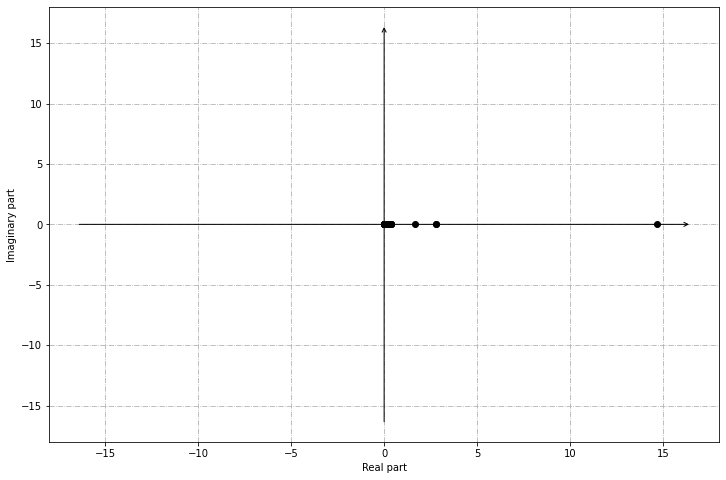

In [16]:
spod.plot_eigs()

We can then plot the **eigenvalues as a function of frequency and period** (note that we multiply the frequency by 24, that is the number of hours in a day, to obtain a period for the x-axis in days). Again, we can see how thorough the `PySPOD` object returned after the computation we can access the frequency array (`spod.freq`) along with the plotting methods `spod.plot_eigs_vs_frequency` and `spod.plot_eigs_vs_period`.

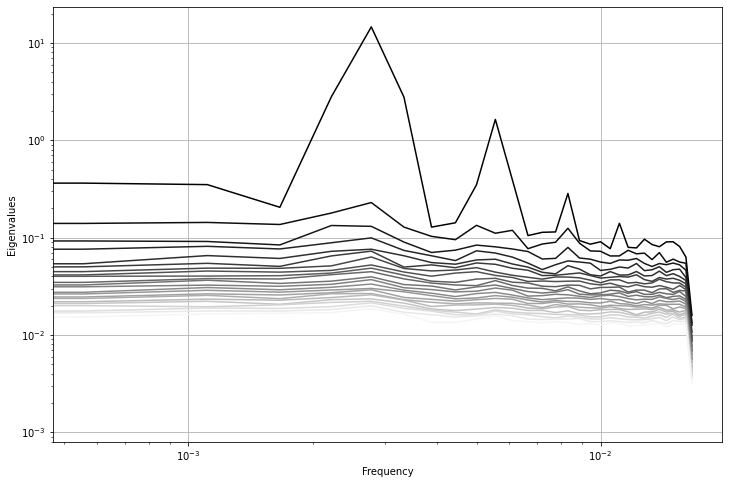

In [17]:
freq = spod.freq*24
spod.plot_eigs_vs_frequency(freq=freq)

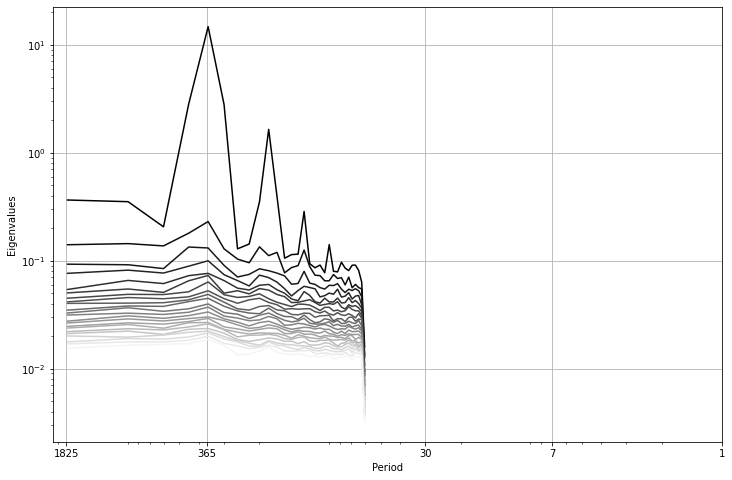

In [18]:
spod.plot_eigs_vs_period   (freq=freq, xticks=[1, 7, 30, 365, 1825])

We can then plot the **modes** that were computed by the SPOD algorithm via the built-in `plot_2D_modes_at_frequency` method, that can again be accessed via the `PySPOD` object returned after the computation. To this method, we pass the frequency of the modes we are interested in. This corresponds to the frequency associated to the T_approx of 876 days that we requested, and stored in the variable `freq_found` that we calculated above. Note that we also pass the `vars_idx` corresponding to the variable we are interested in, modes_idx corresponding to the modes we are interested in, as well as `x1`, and `x2`, that correspond to longitude and latitude. We finally pass a parameter `coastlines='centred'`, that overlays a world map on top of our data. Note that we **shift longitude of 180**, as we use coastlines that goes from -180, to 180, while our data was provided from 0 to 360. 

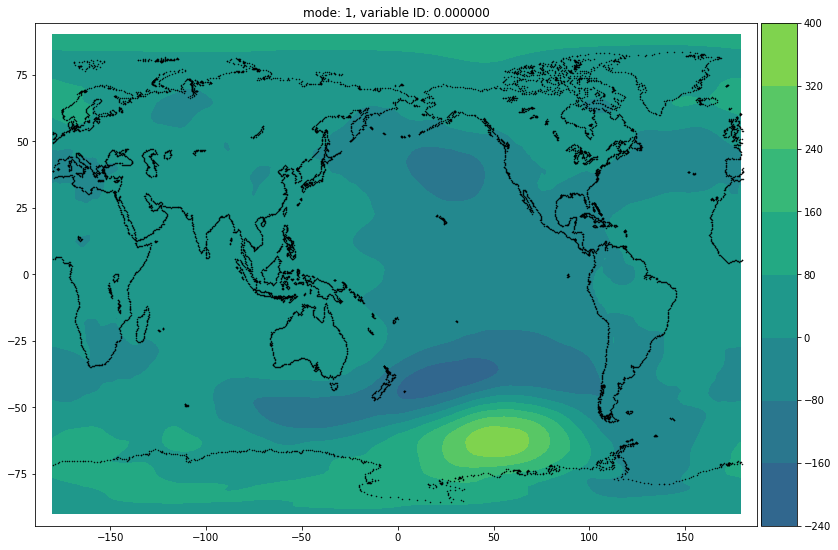

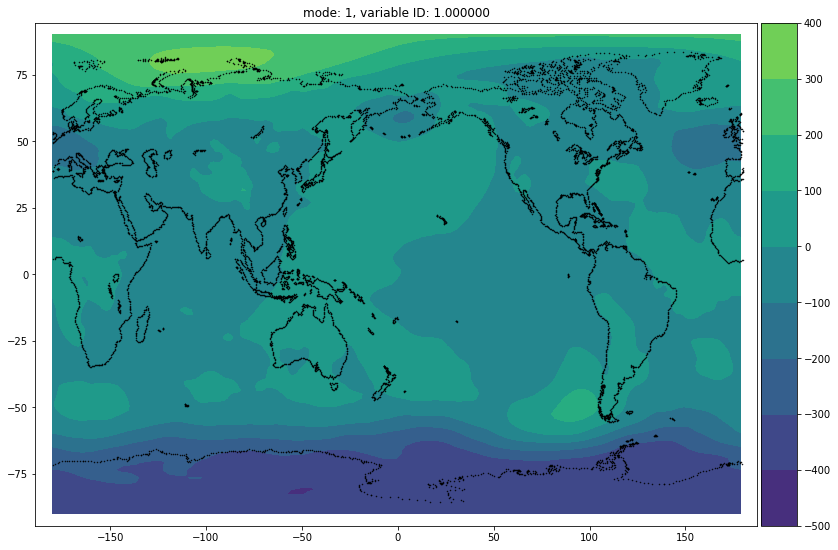

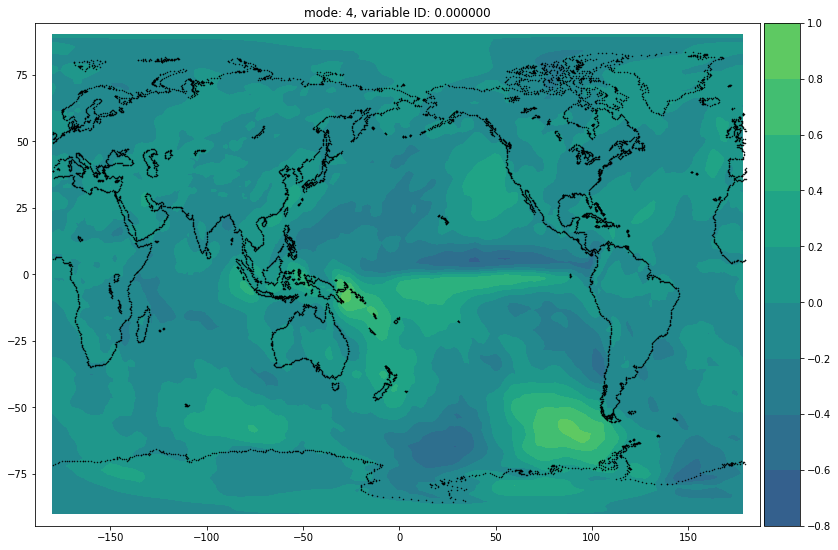

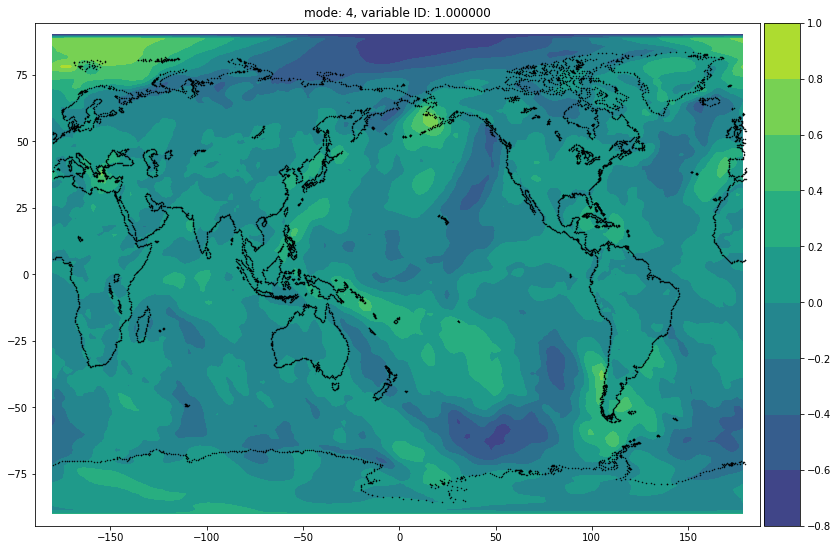

In [19]:
spod.plot_2D_modes_at_frequency(
	freq_required=freq_found, freq=freq, x1=x1-180, x2=x2, coastlines='centred', modes_idx=[0,1], vars_idx=[1,4])

Note that we can also plot the **original data** by

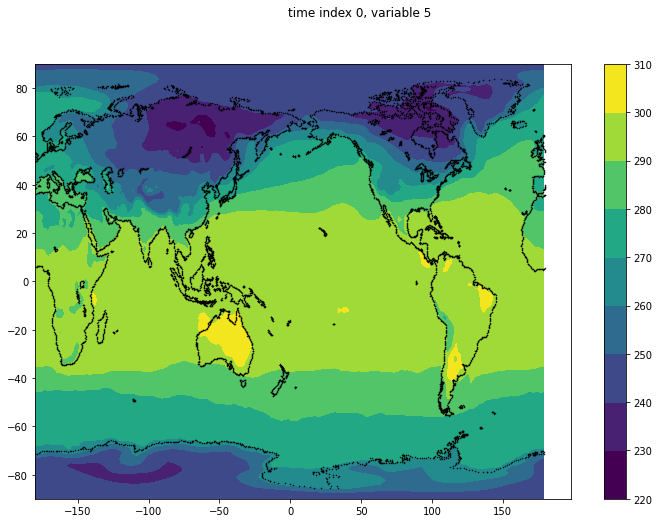

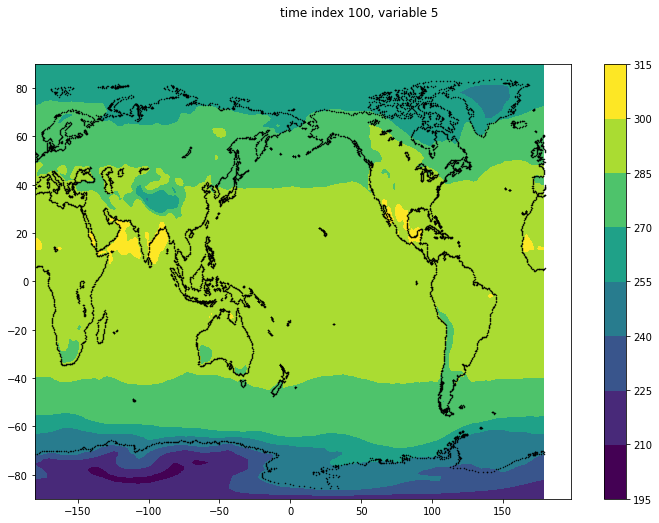

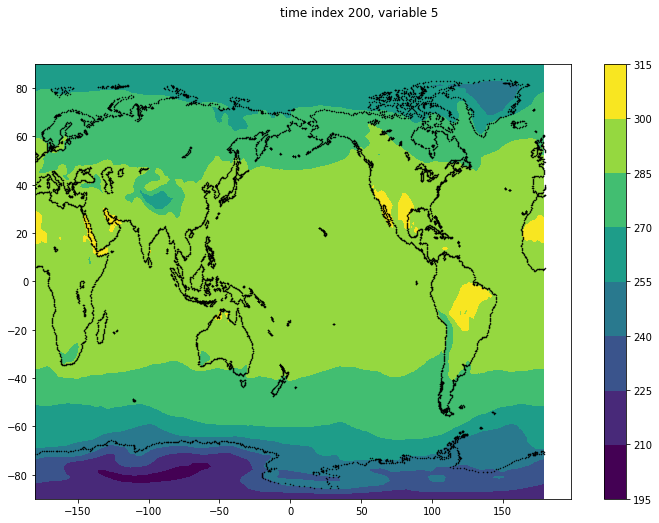

In [24]:
spod.plot_2D_data(x1=x1-180, x2=x2, coastlines='centred', vars_idx=[5], time_idx=[0,100,200])

Along with a video of the original data

In [ ]:
spod.generate_2D_data_video(x1=x1-180, x2=x2, coastlines='centred', vars_idx=[5])

IndexError: index 1332 is out of bounds for axis 0 with size 1332

## Final notes

The results are stored in the results folder defined in the parameter you specified under `params[savedir]`. We can load the results for both modes and eigenvalues, and use any other postprocessing tool that is more suitable to your application. The files are stored in `numpy` binary format `.npy`. There exists several tools to convert them in `netCDF`, `MATLAB` and several other formats that can be better suited to you specific post-processing pipeline.

This tutorial was intended to help you setup your own multivariate case. You can play with the parameters we explored above to gain more insights into the capabilities of the library. You can also run on the same data the other two SPOD algorithms implemented as part of this library by simply calling:
- SPOD_analysis = SPOD_low_ram(X=X, params=params, file_handler=False)
- SPOD_analysis = SPOD_streaming(X=X, params=params, file_handler=False)

and compare the results.